In [2]:
import sys
import os
import importlib

# Ajout du chemin une fois
sys.path.append(os.path.abspath('../python_files'))

# Liste des noms des modules à importer et recharger
module_names = [
    'preprocessing',
    'imports',
    'files',
    'clustering',
    'profile_prediction',
    'prediction_24h'
]

# Import et reload automatique
modules = {}
for name in module_names:
    modules[name] = importlib.import_module(name)
    importlib.reload(modules[name])

# Importer tout en global namespace (équivalent à from ... import *)
for name in module_names:
    exec(f'from {name} import *')



In [11]:

# Exemple d'utilisation
city_groups = {
    "Weather_Dataset": Weather_Dataset
}

prefix_column_map = {
    "Text_": 1,
    "Hum_": 3,
    "Wind_": 4,
    "Solar_": 5,
    "Ground_": 10
}

combined_data = extract_and_combine_all(city_groups, prefix_column_map)

city_groups = {
    "Simulation_Dataset":Simulation_Dataset  
}

prefix_column_map = {
    "Tint_": 2, 
    "conso_":4  
}

combined_Tint = extract_and_combine_all(city_groups, prefix_column_map)

Text_combined = combined_data.get('Text_combined_Weather_Dataset')
Hum_combined = combined_data.get('Hum_combined_Weather_Dataset')
Wind_combined = combined_data.get('Wind_combined_Weather_Dataset')
Tint_combined = combined_Tint.get('Tint_combined_Simulation_Dataset')
conso_combined = combined_Tint.get('conso_combined_Simulation_Dataset')


In [4]:
occupation=extract_columns("../data/simulated_data_7years/Mal_isole/Occupancy_per_hour",1)
occupation_7years = pd.concat([occupation] * 7, ignore_index=True)
clustering_heat = pd.read_csv("../data/simulated_data_7years/conso_kmeans_data/clusters_heat_toulouse_kmeans")
conso=clustering_heat.drop(columns=["heat_on","clusters"])

In [5]:
# 1. Créer le masque des jours où la consommation est non nulle
jours_ouverts_mask = conso.sum(axis=1) != 0

# 2. Filtrer chaque grandeur avec le même masque
occupation_combined_ouvert = occupation_7years[jours_ouverts_mask].reset_index(drop=True)
Text_combined_ouvert = Text_combined[jours_ouverts_mask].reset_index(drop=True)
Hum_combined_ouvert = Hum_combined[jours_ouverts_mask].reset_index(drop=True)
Tint_combined_ouvert = Tint_combined[jours_ouverts_mask].reset_index(drop=True)
conso_ouvert=conso[jours_ouverts_mask].reset_index(drop=True)

In [7]:
occupation_combined_ouvert_flat = pd.DataFrame(occupation_combined_ouvert.values.flatten(), columns=["valeur"])
Text_combined_ouvert_flat = pd.DataFrame(Text_combined_ouvert.values.flatten(), columns=["valeur"])
Hum_combined_ouvert_flat = pd.DataFrame(Hum_combined_ouvert.values.flatten(), columns=["valeur"])
Tint_combined_ouvert_flat = pd.DataFrame(Tint_combined_ouvert.values.flatten(), columns=["valeur"])
conso_ouvert_flat = pd.DataFrame(conso_ouvert.values.flatten(), columns=["valeur"])


In [8]:
df_corr = pd.concat([
    conso_ouvert_flat.rename(columns={"valeur": "conso"}),
    occupation_combined_ouvert_flat.rename(columns={"valeur": "occupation"}),
    Text_combined_ouvert_flat.rename(columns={"valeur": "Text"}),
    Tint_combined_ouvert_flat.rename(columns={"valeur": "Tint"}),
    Hum_combined_ouvert_flat.rename(columns={"valeur": "humidity"})
 
], axis=1)


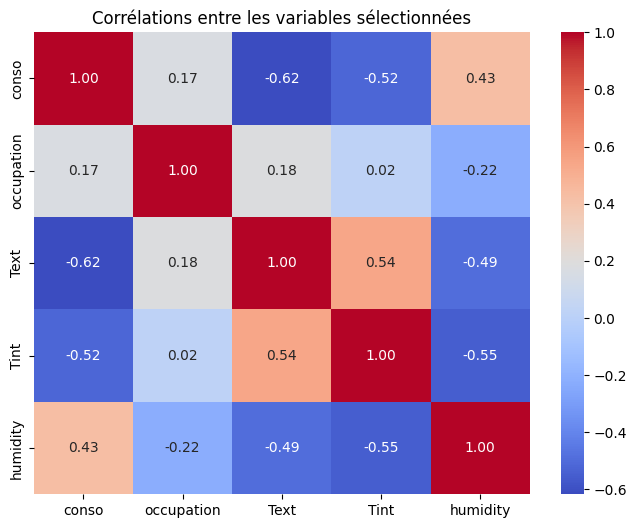

In [9]:
correlation_matrix = df_corr.corr()

# Afficher la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corrélations entre les variables sélectionnées")
plt.show()

### Analyse de corrélation des données entre le 1er novembre et le 30 avril.

In [16]:
start_date = "2018-01-01"
dates = pd.date_range(start=start_date, periods=len(conso_combined), freq="D") 
Text_combined.insert(0, "Date", dates)
Hum_combined.insert(0, "Date", dates)
Tint_combined.insert(0, "Date", dates)
conso_combined.insert(0, "Date", dates)



In [20]:
def add_heating_season(df, date_column='Date'):
    """
    Ajoute une colonne 'heat_on' qui vaut 1 si la date est entre le 1er novembre et le 30 avril, sinon 0.

    """ 
    # Extraire le mois et le jour
    month_day = df[date_column].dt.month * 100 + df[date_column].dt.day
    # Appliquer la condition: 1 si entre 1101 (1er nov) et 0430 (30 avril), sinon 0
    df['heat_on'] = ((month_day >= 1101) | (month_day <= 430)).astype(int)
    return df


add_heating_season(conso_combined)
add_heating_season(Tint_combined)
add_heating_season(Hum_combined)
add_heating_season(Text_combined)

df_conso = conso_combined[conso_combined["heat_on"] == 1].copy()
df_Text = Text_combined[Text_combined["heat_on"] == 1].copy()
df_Hum = Hum_combined[Hum_combined["heat_on"] == 1].copy()
df_Tint = Tint_combined[Tint_combined["heat_on"] == 1].copy()



In [24]:
Text_combined_ouvert_flat = pd.DataFrame(df_Text.drop(columns=['Date']).values.flatten(), columns=["valeur"])
Hum_combined_ouvert_flat = pd.DataFrame(df_Hum.drop(columns=['Date']).values.flatten(), columns=["valeur"])
Tint_combined_ouvert_flat = pd.DataFrame(df_Tint.drop(columns=['Date']).values.flatten(), columns=["valeur"])
conso_ouvert_flat = pd.DataFrame(df_conso.drop(columns=['Date']).values.flatten(), columns=["valeur"])



In [30]:
df_corr = pd.concat([
    conso_ouvert_flat.rename(columns={"valeur": "conso"}),
    Text_combined_ouvert_flat.rename(columns={"valeur": "Text"}),
    Tint_combined_ouvert_flat.rename(columns={"valeur": "Tint"}),
    Hum_combined_ouvert_flat.rename(columns={"valeur": "humidity"})
 
], axis=1)


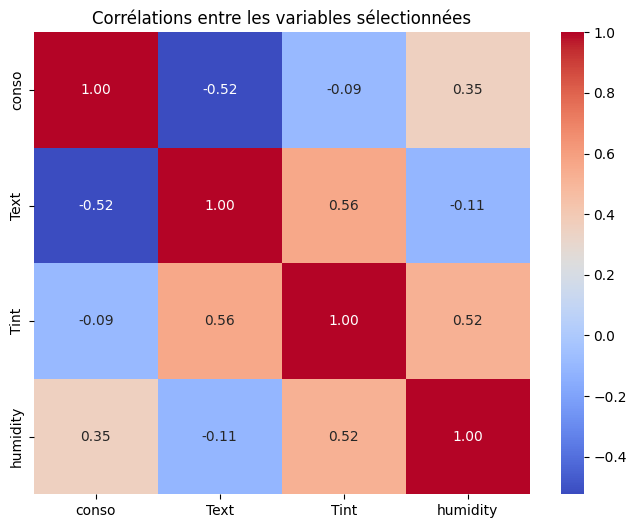

In [31]:
correlation_matrix = df_corr.corr()

# Afficher la heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corrélations entre les variables sélectionnées")
plt.show()